# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import ast
import random

from librosa import display as ld

import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import backend as K

!pip install git+https://github.com/AI-Guru/ngdlm.git
tf.compat.v1.disable_eager_execution()

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from configparser import ConfigParser

  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-izst2j6e
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-izst2j6e
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=486fd46c18dbe102b779972f6ce26c5b0f839fce308713e7b9fefdbdfff96d69
  Stored in directory: /tmp/pip-ephem-wheel-cache-hz6qr5x0/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive
#### 1. First mount

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Mounted at /gdrive
/gdrive/MyDrive/sound-of-failure


#### 2. Remount

In [3]:
%cd ../../..
drive.flush_and_unmount()
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/sound-of-failure

/
Mounted at /gdrive
/gdrive/My Drive/sound-of-failure


# Import Own Modules

In [4]:
sys.path += ['src/00_utils', 'src/01_data_processing', 'src/02_modelling', 'src/03_modell_evaluation',]

import spectrogram as spec
import train_test_split as splt
import train_model_autoencoder as train
import eval_model_autoencoder as eval
import threshold_recoloss as thres
import naming

# Global constants

### First run the scripts for building the config files.

Some of the parameters can be passed through the command line.
At present the command line parameters are the following :

1. conf_base.py : Script for building the base config file (saves in sound-of-failure/conf/conf_base.ini)
        -raw : Pass the location of the raw data dir
        -prj : Pass the directory hosting sound-of-failure


2. conf_convAE.py : Script for building the config file holding the parameters for Mel Spectrogram and Convolutional Autoencoder (saves in sound-of-failure/conf/make_conf_convAE.ini). Convolutional Autoencoders can be either Autoencoders or Variational Autoencoders.
        -prj : Pass the directory hosting sound-of-failure
        -ae : AE or VAE
        -mel : No. of mels
        -fft : No. of FFT bands
        -hop : Hop length for the sliding window while calculating FFT
        -dim : Time dimension of one spectrogram block after chunking the whole spectrogram
        -s : Step for the sliding window for creating chunks from one spectrogram


To check the description of the command line parameters one could activate the '-h' flag. For example :

In [5]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_AE.py -h

usage: make_conf_AE.py [-h] -prj _ [-ae] [-noise] [-type] [-id] [-mel] [-fft]
                       [-hop] [-dim] [-s]

Params for Spectrogram and Autoencoder (AE, VAE or lstmAE)

optional arguments:
  -h, --help            show this help message and exit
  -prj _, --project _   directory hat holds sound-of-failure
  -ae , --ae            Type of Autoencoder (AE, VAE or lstmAE)
  -noise , --noise      Level of background noise (6dB, 0dB or min6dB)
  -type , --type        Type of machine (valve, slider, pump or fan)
  -id , --id            Machine ID (e.g. id_00)
  -mel , --n_mels       No. of mel bands
  -fft , --n_fft        No. of FFT bands
  -hop , --hop_length   Hop length for FFT calc
  -dim , --dim          Time dimension of Spectrogram block
  -s , --step           Sliding window step for Spectrogram chunking


#### Note the change here : While running VAE we have to specify -ae to VAE in the command line. This ensures that the right config file is created (conf/conf_VAE.ini).

In [6]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_base.py -raw '/gdrive/MyDrive/Hitachi_data/dataset' -prj '/gdrive/MyDrive'
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_AE.py -prj '/gdrive/MyDrive' -ae VAE -noise 6dB -type valve -id id_00 -mel 32 -fft 1024 -hop 256 -dim 64 -s 8

### Then read from the config files

There are two config files : 

1. sound-of-failure/conf/**conf_base**.ini
2. sound-of-failure/conf/**conf_VAE**.ini

##### Note the change here : In normal Autoencoders the created config file is called conf_convAE.ini. Now is is called conf_VAE.ini.

In [7]:
base_conf = train.read_config('conf/conf_base.ini')

In [8]:
naming.show_run_ids()

,run_id,conf,scaler,model,comment
0,VAE_6dB_valve_id_00,True,True,True,Default run ID. Archive run to prevent overwri...
1,VAE_6dB_valve_id_00_final,True,True,True,
2,VAE_6dB_valve_id_06,True,True,True,Default run ID. Archive run to prevent overwri...
3,conf_VAE,True,False,False,
4,conf_convAE,True,False,False,


In [9]:
run_id = 'VAE_6dB_valve_id_00'

conf_path = naming.get_conf_path(run_id)
param_conf = train.read_config(conf_path)

#### Read the parameters directly from the config files

Question : Should the reading of config files be done within notebooks or the source script should directly read from them?

In [10]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
MODEL_NAME = param_conf.get('autoencoder', 'model_name')

if MODEL_NAME == 'lstmAE':
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'))
elif MODEL_NAME in ['AE', 'VAE']:
    LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
    NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
    NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
    NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
    NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))
    INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
                   param_conf.getint('melspec', 'n_mels'),
                   1)
else:
    print('Invalid model name.')


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Execute preprocessing steps
#### 1. Generate unscaled mel spectrograms (~ 5 minutes)

In [11]:
spec.make_mel_dirs(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)

spec.make_mels(RAW_DATA_DIR, BASE_DIR, 
               DB, MACHINE_TYPE, MACHINE_ID, 
               N_MELS, N_FFT, HOP_LENGTH, POWER, WINDOW, overwrite=True)

Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal
Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal


  0%|          | 0/991 [00:00<?, ?it/s]

Generate normal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal.


  0%|          | 0/119 [00:00<?, ?it/s]

Created 991 new spectrograms, kept 0 existing spectrograms.
Generate abnormal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal.


100%|██████████| 119/119 [01:09<00:00,  1.71it/s]

Created 119 new spectrograms, kept 0 existing spectrograms.


#### 2. Separate train and test files

In [11]:
train_files, train_labels, test_files, test_labels = splt.make_train_test_split(BASE_DIR, 
                                                                                DB, MACHINE_TYPE, MACHINE_ID, 
                                                                                random_seed=1)

#### 3. Separate train and validation files

In [13]:
train_files, val_files, train_labels, val_labels = train_test_split(train_files, 
                                                                    train_labels, 
                                                                    test_size=0.2,
                                                                    shuffle=True,
                                                                    random_state=42)

#### 3. Fit scaler to train files

#### 3.1 Plot an example spectrogram

Just a sanity check

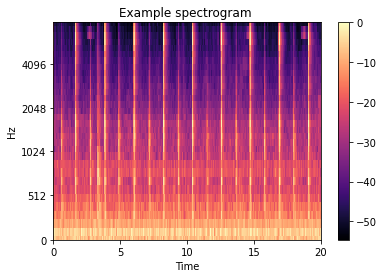

In [14]:
spect = np.load(spec.get_normal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0])

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

In [15]:
scaler_path = naming.get_scaler_path(run_id)
scaler = spec.fit_and_save_scaler(SCALER_TYPE, train_files, scaler_path, overwrite=True)

  8%|▊         | 53/697 [00:00<00:01, 524.35it/s]

Overwriting existing scaler models/VAE_6dB_valve_id_00.gz.


100%|██████████| 697/697 [00:01<00:00, 530.00it/s]


Saving scaler to models/VAE_6dB_valve_id_00.gz.


#### 4. Generate training data from scaling and subsampling mel spectrograms

In [16]:
MODEL_NAME

'VAE'

In [17]:
if MODEL_NAME == 'lstmAE':
  train_data = splt.generate_train_data(train_files, scaler, DIM, STEP, as_images=False)
else:
  train_data = splt.generate_train_data(train_files, scaler, DIM, STEP, as_images=True)

100%|██████████| 697/697 [00:43<00:00, 16.19it/s]


In [18]:
train_data.shape

(50184, 64, 32, 1)

#### 5. Generate validation data from scaling and subsampling mel spectrograms

In [19]:
if MODEL_NAME == 'lstmAE':
  val_data = splt.generate_train_data(val_files, scaler, DIM, STEP, as_images=False)
else:
  val_data = splt.generate_train_data(val_files, scaler, DIM, STEP, as_images=True)

100%|██████████| 175/175 [00:03<00:00, 47.59it/s]


In [ ]:
val_data.shape

(12600, 64, 32, 1)

# Modelling

### Build Variational Autoencoder

While training a new model the model should be called fresh from `train/load_new_model`. 

For prediction or model evaluation, one should call `train/load_saved_model`



In [ ]:
my_model = train.load_new_model(model_name='VAE',
                                input_shape=INPUT_SHAPE,
                                num_nodes=NUM_NODES,
                                num_kernel=NUM_KERNEL,
                                num_strides=NUM_STRIDES,
                                latent_dim=LATENT_DIM)

print(my_model.summary())

Encoder:
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv_enc0 (Conv2D)              (None, 64, 16, 32)   832         encoder_input[0][0]              
__________________________________________________________________________________________________
batchnorm_enc0 (BatchNormalizat (None, 64, 16, 32)   128         conv_enc0[0][0]                  
__________________________________________________________________________________________________
relu_enc0 (ReLU)                (None, 64, 16, 32)   0           batchnorm_enc0[0][0]             
___________________________________________________________________________________

#### NOTE THE CHANGE : 
    1. `train.compile_model`: Now the model is compiled with a learning rate that can be specified by the user. Currently three optimizers can be chosen:
      -Adam
      -RMSprop
      -SGD

    2. train.train_model: In the model training there are two options:
      A. Train with callbacks: If callback=True, then EarlyStopping and ModelCheckpoint is enabled. In that case a patience and a path to save the best model must be specified.
      B. Train without callbacks: Set callback=False in that case. No EarlyStopping and also the best model will not be saved.





Train on 50184 samples, validate on 12600 samples
Epoch 1/100
50184/50184 [==============================] - ETA: 0s - loss: 0.1536

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.07161, saving model to models/VAE_6dB_valve_id_00.hdf5
50184/50184 [==============================] - 45s 898us/sample - loss: 0.1536 - val_loss: 0.0716
Epoch 2/100
50176/50184 [============================>.] - ETA: 0s - loss: 0.0603
Epoch 00002: val_loss improved from 0.07161 to 0.06547, saving model to models/VAE_6dB_valve_id_00.hdf5
50184/50184 [==============================] - 26s 510us/sample - loss: 0.0603 - val_loss: 0.0655
Epoch 3/100
50184/50184 [==============================] - ETA: 0s - loss: 0.0545
Epoch 00003: val_loss improved from 0.06547 to 0.05581, saving model to models/VAE_6dB_valve_id_00.hdf5
50184/50184 [==============================] - 25s 507us/sample - loss: 0.0545 - val_loss: 0.0558
Epoch 4/100
50184/50184 [==============================] - ETA: 0s - loss: 0.0514
Epoch 00004: val_loss did not improve from 0.05581
50184/50184 [==============================] - 25s 494us/sample - loss: 0.0514 - val_loss: 0.0764
Ep

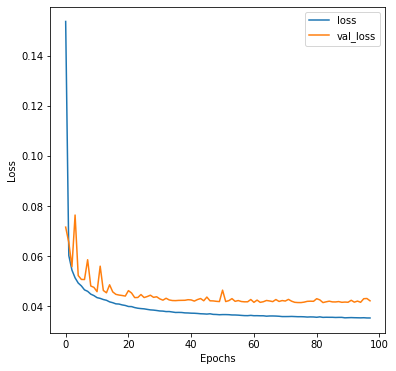

In [ ]:
# Compile model
train.compile_model(model=my_model, 
              optimizer=OPTIMIZER, 
              loss=LOSS, 
              learning_rate=0.001)

model_path = naming.get_model_path(run_id)

# Train model
history = train.train_model(model=my_model,
                            train_data=train_data,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            validation_split=VALIDATION_SPLIT,
                            validation_data=val_data,
                            shuffle=SHUFFLE,
                            callback=True,
                            patience=15,
                            model_outdir=model_path)

# Plot model history
train.plot_train_history(history)

# Model evaluation


In [ ]:
"""saved_model = train.load_saved_model('/gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5')

y_pred = np.zeros(len(test_files))
y_true = test_labels

for idx, test_file in tqdm.tqdm(enumerate(test_files), total=len(test_files)):
  #print("File no.={}, location={}, label={}".format(idx, test_file, test_label))

  mel = np.load(test_file)

  scaled_mel = spec.apply_scaler_to_mel(scaler, mel)

  batch = splt.subsample_from_mel(scaled_mel, DIM, STEP)

  batch_prediction = saved_model.predict(batch)

  squared_error = np.square(batch - batch_prediction)
  channelwise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(channelwise_error)

  y_pred[idx] = reconstruction_error


auc_score = metrics.roc_auc_score(y_true, y_pred)
print("Roc AUC score={}".format(auc_score))"""

'saved_model = train.load_saved_model(\'/gdrive/MyDrive/sound-of-failure/models/00_trial_VAE.hdf5\')\n\ny_pred = np.zeros(len(test_files))\ny_true = test_labels\n\nfor idx, test_file in tqdm.tqdm(enumerate(test_files), total=len(test_files)):\n  #print("File no.={}, location={}, label={}".format(idx, test_file, test_label))\n\n  mel = np.load(test_file)\n\n  scaled_mel = spec.apply_scaler_to_mel(scaler, mel)\n\n  batch = splt.subsample_from_mel(scaled_mel, DIM, STEP)\n\n  batch_prediction = saved_model.predict(batch)\n\n  squared_error = np.square(batch - batch_prediction)\n  channelwise_error = np.mean(squared_error, axis=-1)\n  reconstruction_error = np.mean(channelwise_error)\n\n  y_pred[idx] = reconstruction_error\n\n\nauc_score = metrics.roc_auc_score(y_true, y_pred)\nprint("Roc AUC score={}".format(auc_score))'

### Load trained model

In [14]:
model_path = naming.get_model_path(run_id)
saved_model = train.load_saved_model(model_path)

In [15]:
"""### Rename trained model
new_run_id = 'VAE_6dB_valve_id_00_final'
naming.copy_run(run_id, new_run_id)"""

"### Rename trained model\nnew_run_id = 'VAE_6dB_valve_id_00_final'\nnaming.copy_run(run_id, new_run_id)"

### Load fitted scaler

In [16]:
path_saved_scaler = naming.get_scaler_path(run_id)
saved_scaler = spec.load_saved_scaler(path_saved_scaler)

### Reconstruction error and ROC curve

In [17]:
MODEL_NAME

'VAE'

In [18]:
# Reconstruction loss for test and train spectrograms
if MODEL_NAME == 'lstmAE':
  as_images = False
else:
  as_images = True


# Reconstruction loss for test and train spectrograms
reco_loss_test = eval.reco_loss(model=saved_model,
                                scaler=saved_scaler,
                                dim=DIM,
                                step=STEP,
                                test_files=test_files,
                                as_images=as_images)

reco_loss_train = eval.reco_loss(model=saved_model, 
                                scaler=saved_scaler,
                                dim=DIM,
                                step=STEP,
                                test_files=train_files,
                                as_images=as_images)

reco_loss_val = eval.reco_loss(model=saved_model,
                               scaler=saved_scaler,
                               dim=DIM,
                               step=STEP,
                               test_files=val_files,
                               as_images=as_images)

  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 140/140 [01:13<00:00,  1.90it/s]


Roc AUC score=0.9707647764988347


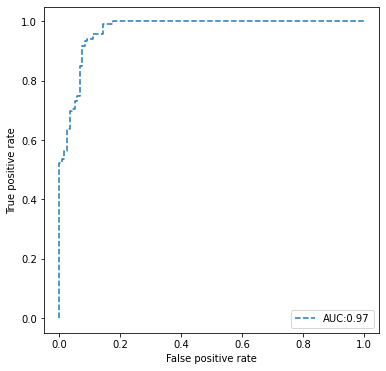

In [19]:
# ROC curve and ROC AUC score (for test data)
eval.plot_roc_curve(test_labels, reco_loss_test)

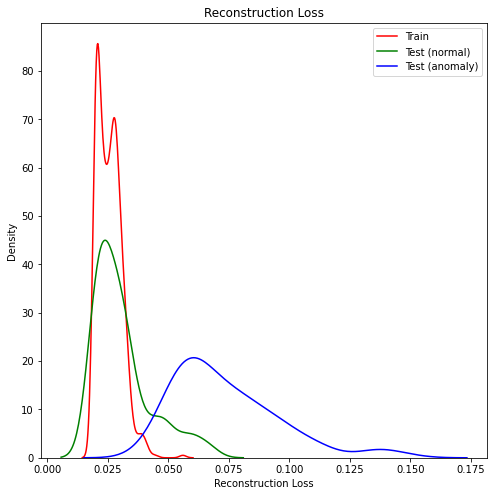

In [20]:
# Visualize separation between normal and abnormal reconstruction loss
eval.plot_losses(y_true=test_labels,
                  y_pred=reco_loss_test,
                  y_train=reco_loss_train,
                  title="Reconstruction Loss",
                  xlabel='Reconstruction Loss')

### Thresholding the reconstruction loss

The threshold on the reconstruction can be calculated in two ways :
  - Either by using a percentile measure (e.g. all reco loss greater than 90-th percentile of the validation reco loss will be tagged as anomalies)
  - Or by using std deviation (e.g. all reco loss greater than 1 std. dev away
  from the mean validation reco loss will be tagged as anomalies)

Here since we have access to the test data, a range of such thresholds is provided and the precision score, recall score and accuracy on the test data is calculated for each such threshold.

In [21]:
# When median and IQR measure is used for thresholding
# Range of IQR to try for thresholding
iqr_range = np.arange(0.5, 2.0, step=0.1)

metrics_df = thres.metrics_by_variable_threshold(validation_loss=reco_loss_val, 
                                                 test_loss=reco_loss_test, 
                                                 test_labels=test_labels, 
                                                 measure='iqr', 
                                                 criterion_range=iqr_range)

criterion_iqr = thres.get_threshold_criterion(metrics_df, 'Fbeta_score')
metrics_df.head(30)

The threshold that provides the best Fbeta_score with value 0.9818481848184819 corresponds to 1.8 iqr


,iqr,Threshold,Precision,Recall,Fbeta_score
0,0.5,0.028149,0.683908,1.0,0.955823
1,0.6,0.028900,0.691860,1.0,0.957361
2,0.7,0.029652,0.700000,1.0,0.958904
3,0.8,0.030404,0.712575,1.0,0.961228
4,0.9,0.031156,0.743750,1.0,0.966694
5,1.0,0.031908,0.762821,1.0,0.969845
6,1.1,0.032660,0.777778,1.0,0.972222
7,1.2,0.033412,0.804054,1.0,0.976210
8,1.3,0.034164,0.809524,1.0,0.977011
9,1.4,0.034916,0.815068,1.0,0.977814


In [22]:
# When percentile measure is used for thresholding
# Range of percentiles to try for thresholding
perc_range = np.arange(85, 100, step=1)

metrics_df = thres.metrics_by_variable_threshold(validation_loss=reco_loss_val, 
                                                 test_loss=reco_loss_test, 
                                                 test_labels=test_labels, 
                                                 measure='percentile', 
                                                 criterion_range=perc_range)
criterion_percentile = thres.get_threshold_criterion(metrics_df, 'Fbeta_score')
metrics_df.head(30)

The threshold that provides the best Fbeta_score with value 0.9818481848184819 corresponds to 99 percentile


,percentile,Threshold,Precision,Recall,Fbeta_score
0,85,0.030450,0.712575,1.0,0.961228
1,86,0.030513,0.716867,1.0,0.962005
2,87,0.030691,0.730061,1.0,0.964344
3,88,0.030735,0.739130,1.0,0.965909
4,89,0.030784,0.739130,1.0,0.965909
5,90,0.031020,0.743750,1.0,0.966694
6,91,0.031941,0.762821,1.0,0.969845
7,92,0.032245,0.762821,1.0,0.969845
8,93,0.032450,0.777778,1.0,0.972222
9,94,0.032724,0.793333,1.0,0.974611


Now let's say we have a new dataset (say a new machine_id of valve). For this machine_id we do not know the optimal threshold. Hence our aim would be to use the experience from the previous evaluation, i.e. use the same thresholding criterion that gave a good metric there and check whether that chosen threshold provides reasonable results on our new machine_id.

Here the usage is shown on id_00 only. But in the actual test the following lines of code should be used to evaluate a different machine_id of valve.

In [23]:
# Let's say we choose 'iqr' as the measure for thresholding
iqr = criterion_iqr # obtained from previous experience of evaluating id_00
threshold_iqr = thres.set_threshold(validation_loss=reco_loss_val, 
                                    criterion_dict=iqr)
print("The obtained threshold for validation reco loss = {}".format(threshold_iqr))

# Calculate the metric values on the test for the threshold obtained from the validation data
pred_test_labels = thres.predicted_labels(reco_loss=reco_loss_test,
                                           thres=threshold_iqr)

prec_test, recall_test, fbeta_test = thres.calculate_metrics(test_labels, pred_test_labels)
print("Printing metrics obtained on the test data using the threshold obtained from the validation data...")
print("Precision={}".format(prec_test))
print("Recall={}".format(recall_test))
print("Fbeta_score={}".format(fbeta_test))

The obtained threshold for validation reco loss = 0.03792423997074366
Printing metrics obtained on the test data using the threshold obtained from the validation data...
Precision=0.8439716312056738
Recall=1.0
Fbeta_score=0.9818481848184819


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


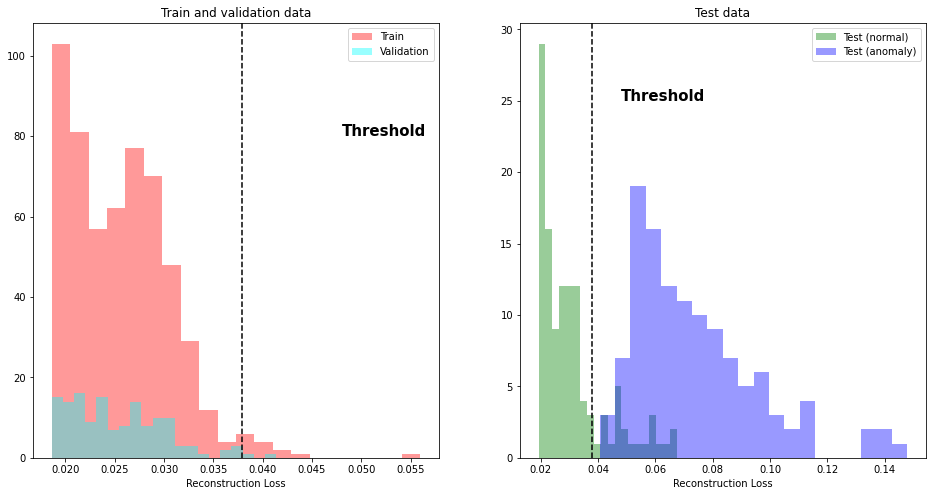

In [24]:
# Visualize separation between normal and abnormal reconstruction loss
eval.plot_losses(y_true=test_labels,
                  y_pred=reco_loss_test,
                  y_train=reco_loss_train,
                  y_val=reco_loss_val,
                  thres=threshold_iqr,
                  title="Reconstruction Loss",
                  xlabel='Reconstruction Loss')

### KL Divergence loss

In [ ]:
# KL-divergence for the test and train spectrograms
kl_loss_test = eval.kl_loss(model=my_model, 
                            scaler=scaler,
                            dim=DIM,
                            step=STEP,
                            test_files=test_files)

kl_loss_train = eval.kl_loss(model=my_model, 
                            scaler=scaler,
                            dim=DIM,
                            step=STEP,
                            test_files=train_files)

  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 697/697 [05:06<00:00,  2.27it/s]


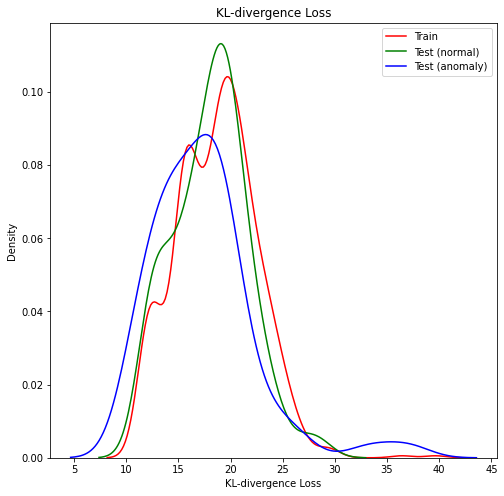

In [ ]:
# Visualize separation between normal and abnormal KL_divergence loss
eval.plot_losses(y_true=test_labels,
                 y_pred=kl_loss_test,
                 y_train=kl_loss_train,
                 title="KL-divergence Loss",
                 xlabel='KL-divergence Loss')